In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint,solve_ivp

# Reservoir

In [ ]:
class Reservoir:

    def __init__(self,in_out_dim=3, rho=1.1, n_neurons=300):
        self.in_out_dim = in_out_dim
        self.n_neurons = n_neurons

        A = np.random.uniform(low=-1,high=1, size=(self.n_neurons,self.n_neurons)) * (np.random.rand(self.n_neurons,self.n_neurons)<0.08).astype(float)
        _,S,_ = np.linalg.svd(A)

        self.W = (A/np.amax(S))*rho

        #other weights
        self.wIN = np.random.uniform(low=-0.3,high=0.3,size=(self.n_neurons,in_out_dim))
        self.wOUT = np.zeros((in_out_dim,self.n_neurons)).astype(float)

        #initialize memory
        self.r = np.zeros([self.n_neurons,1])

    def sigmoid(self,x):
      return np.where(x >= 0, 1 / (1 + np.exp(-x)), np.exp(x) / (1 + np.exp(x)))

    def step(self,x):
        x = np.array(x).reshape([self.in_out_dim,1])
        self.r = self.sigmoid(np.matmul(self.W,self.r)+np.matmul(self.wIN,x))
        O = np.matmul(self.wOUT,self.r)

        return O

    def clear_memory(self):
        self.r = np.zeros([self.n_neurons,1])

    def train(self,X,verbose=False):
        k = 0.000001
        T = X.shape[1]-1

        R = np.zeros([self.n_neurons,self.n_neurons])
        Q = np.zeros([self.n_neurons,self.in_out_dim])

        for t in range(0,T):
            if verbose:print("\riteration:{}/{}".format(t+1,T),end='')
            Yt = np.array(X[:,t+1]).reshape([self.in_out_dim,1])
            Ot = self.step(X[:,t])

            R += np.matmul(self.r,self.r.transpose())
            Q += np.matmul(self.r,Yt.transpose())
        if verbose:
            print()
            print("computing...")

        self.wOUT = np.matmul(np.linalg.inv(R+k*np.eye(self.n_neurons)),Q).transpose()
        if verbose:print('done!')


# Van der Pool

In [ ]:
def F_van_der_Pool(t,x,gamma=1):
 F1 = gamma*(x[0] - (x[0]**3)/3 - x[1])
 F2 = x[0]/gamma
 return np.array([F1,F2])

2000
(2, 2000)


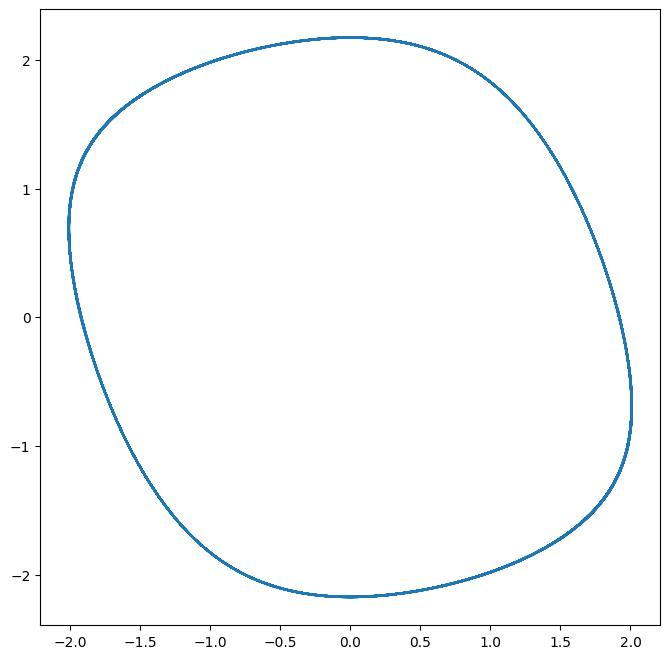

In [ ]:
dt = 0.1
T = 200
N = int(T/dt)
times = np.linspace(0,T,N)

plt.rcParams['figure.figsize'] = [8, 8]
X0 = np.array([[1, 2]])
N0 = int(10/dt)

for i in range(len(X0)):
 solution = solve_ivp(F_van_der_Pool, [0,T], X0[i], t_eval=times) #odeint(F,X0[i],times)
 times = solution.t
 print(len(times))
 sol = solution.y
 plt.plot(sol[0,N0:],sol[1,N0:])
 #ax.plot3D(sol[0,N0:],sol[1,N0:],sol[2,N0:],color="C0")
 X = sol

print(np.array(X).shape)

## Test Reservoir on Van der Pool

In [ ]:
#GENERATE DATA
dt = 0.1
T = 200
times = np.arange(0,T,dt)
IV = [1, 2]
sol = solve_ivp(F_van_der_Pool, [0,T], IV, t_eval=times)
X = sol.y

#90%
split_indx = int(len(times)*0.5)
times_train = times[:split_indx]
X_train = X[:,:split_indx]
print(X_train.shape)


times_val = times[split_indx:]
X_val = X[:,split_indx:]
print(X_val.shape)

(2, 1000)
(2, 1000)


In [ ]:
#define and train on data
res = Reservoir(in_out_dim=2,rho=0.001)
_,S,_ = np.linalg.svd(res.W)
print(f"Singular value of memory layer:{S.max():.3f}")
res.clear_memory()
res.train(X_train,verbose=True)

Singular value of memory layer:0.001
iteration:999/999
computing...
done!


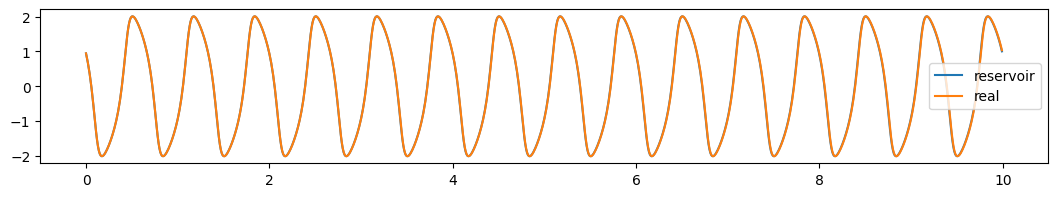

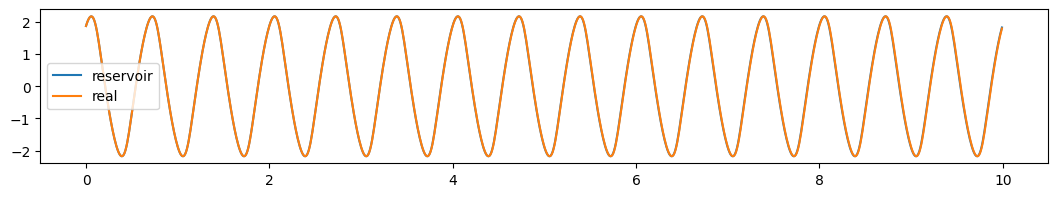

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


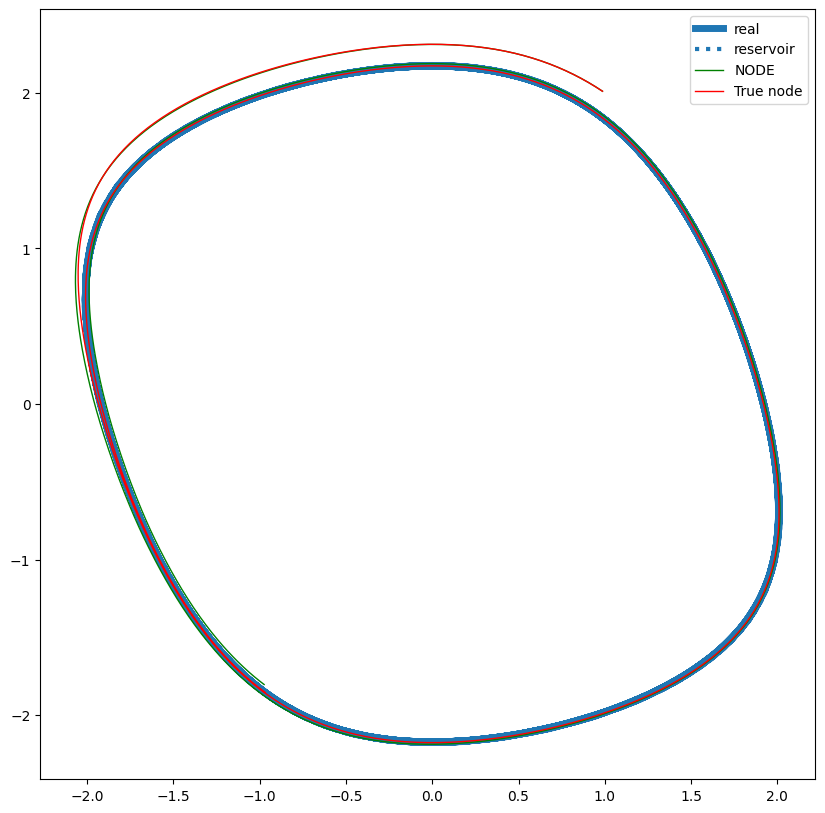

In [ ]:
plt.rcParams['figure.figsize'] = [13, 2]

X_pred = np.zeros(X_val.shape)
X_pred[:,0] = X_val[:,0]
for t in range(1,X_pred.shape[1]):
  X_pred[:,t] = res.step(X_pred[:,t-1]).reshape(2)

# predicted_time = max_predicted_time(X_pred,X_val)
# print(f"accordance up to:{predicted_time}")

max_T = 10
I = np.arange(0,max_T,dt)
for d in range(2):
  plt.plot(I,X_pred[d,:int(max_T/dt)],label="reservoir")
  plt.plot(I,X_val[d,:int(max_T/dt)],label="real")
  #plt.plot(predicted_time*np.ones(2), [X_pred.min(),X_pred.max()],'k--', label="divergence time")
  plt.legend()
  plt.show()

plt.figure(figsize=(10,10))
END = int(max_T/dt)

#load NODE results from Google drive
from google.colab import drive
drive.mount('/content/drive')
X_node = np.array(np.load('/content/drive/MyDrive/AdvancedNN/Project/node_van_der_pol.npy'))
X_true_node = np.array(np.load('/content/drive/MyDrive/AdvancedNN/Project/true_van_der_pol.npy'))

plt.plot(X_val[0,:END],X_val[1,:END],color='C0',label='real', linewidth=5)
plt.plot(X_pred[0,:END],X_pred[1,:END],color="C0",label='reservoir', alpha=1,linestyle=':',linewidth=3)
plt.plot(X_node[0,:END],X_node[1,:END],color="g", label='NODE', alpha=1,linewidth=1)
plt.plot(X_true_node[0,:END],X_true_node[1,:END],color="r", label='True node', alpha=1,linewidth=1)
plt.legend()
plt.show()

# Lotka-Volterra

In [ ]:
def F_Lotka_Volterra(t,x,alpha=1/2,beta=1,delta=1,gamma=1/2):
 F1 = alpha*x[0] - beta*x[0]*x[1]
 F2 = delta*x[0]*x[1] - gamma*x[1]
 return .5*np.array([F1,F2])

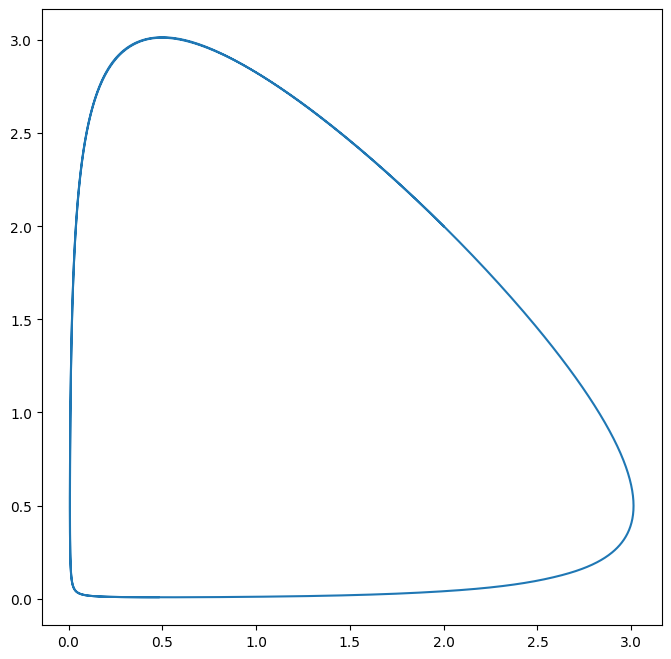

In [ ]:
dt = 0.01
T = 70
N = int(T/dt)
times = np.linspace(0,T,N)

plt.rcParams['figure.figsize'] = [8, 8]
X0 = np.array([[2,2]])
N0 = int(0/dt)


solution = solve_ivp(F_Lotka_Volterra, [0,T], X0[0], t_eval=times, method='RK45') #odeint(F,X0[i],times)
times = solution.t
sol = solution.y
plt.plot(sol[0,N0:],sol[1,N0:])
X = sol


In [ ]:
#GENERATE DATA
dt = 0.01
T = 140
times = np.arange(0,T,dt)
sol = solve_ivp(F_Lotka_Volterra, [0,T], [1,1], t_eval=times)
X = sol.y

ratio = 0.5
split_indx = int(len(times)*ratio)
times_train = times[:split_indx]
X_train = X[:,:split_indx]
print(X_train.shape)


times_val = times[split_indx:]
X_val = X[:,split_indx:]
print(X_val.shape)

(2, 7000)
(2, 7000)


In [ ]:
#define and train on data
res = Reservoir(in_out_dim=2,rho=0.001)
_,S,_ = np.linalg.svd(res.W)
print(f"Singular value of memory layer:{S.max():.3f}")
res.clear_memory()
res.train(X_train,verbose=True)

Singular value of memory layer:0.001
iteration:6999/6999
computing...
done!


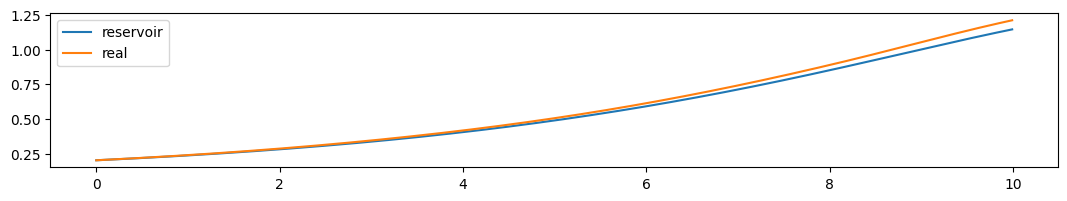

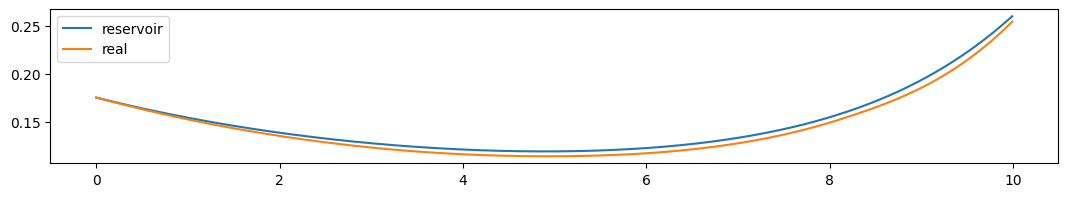

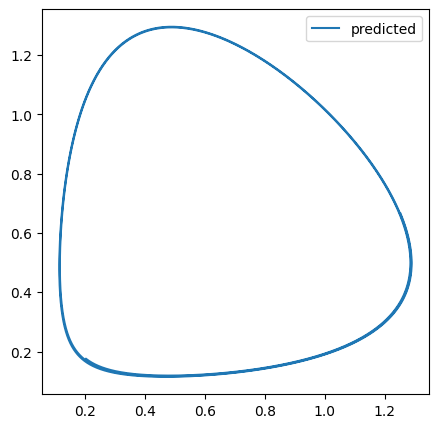

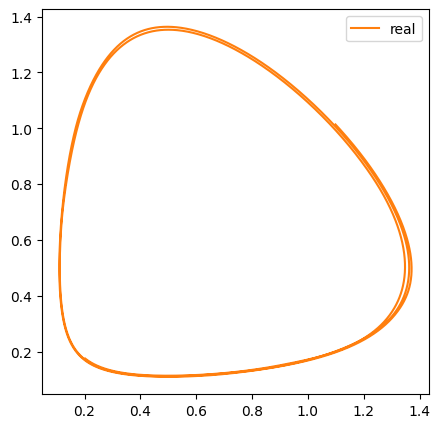

In [ ]:
plt.rcParams['figure.figsize'] = [13, 2]

X_pred = np.zeros(X_val.shape)
X_pred[:,0] = X_val[:,0]
for t in range(1,X_pred.shape[1]):
  X_pred[:,t] = res.step(X_pred[:,t-1]).reshape(2)

# predicted_time = max_predicted_time(X_pred,X_val)
# print(f"accordance up to:{predicted_time}")

max_T = 10
I = np.arange(0,max_T,dt)
for d in range(2):
  plt.plot(I,X_pred[d,:int(max_T/dt)],label="reservoir")
  plt.plot(I,X_val[d,:int(max_T/dt)],label="real")
  #plt.plot(predicted_time*np.ones(2), [X_pred.min(),X_pred.max()],'k--', label="divergence time")
  plt.legend()
  plt.show()

plt.figure(figsize=(5,5))
plt.plot(X_pred[0,:],X_pred[1,:],label='predicted')
plt.legend()
plt.show()
plt.figure(figsize=(5,5))
plt.plot(X_val[0,:],X_val[1,:],color='C1',label='real')
plt.legend()
plt.show()
